# Dump hdf5 input files with RAIL utils

- creation date : March 18th 2021
- last update : May 9th 2021


Check directly the content of HDF5 using **utils.py**

In [118]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,6)
import seaborn as sns 
import scipy.stats
import sys
import os
import pandas as pd
#sys.path.append('../')
import h5py
#from delight.io import *
#from delight.utils import *
#from delight.photoz_gp import PhotozGP

from rail.estimation.utils  import load_training_data, get_input_data_size_hdf5,load_raw_hdf5_data

In [119]:
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

# Info LSST

In [120]:
filt_name= np.array(["u",  "g",  "r",  "i",  "z",  "y"])
mag_max  = np.array([26.1, 27.4, 27.5, 26.8, 26.1, 24.9])
mag_min  = np.array([23.9, 25.0, 24.7, 24.0, 23.3, 22.1])

# Read hdf5 file with rail utils

In [121]:
files = ["training_100gal.hdf5","validation_10gal.hdf5","test_dc2_training_9816.hdf5","test_dc2_validation_9816.hdf5"]

In [122]:
index=3 # access the biggest file
filename = files[index] 

In [123]:
f=load_raw_hdf5_data(filename , groupname='photometry')

## Utility Functions

- conversion format
- selection

In [124]:
def group_entries(f):
    """
    group entries in single numpy array
    
    """
    galid = f['id'][()][:,np.newaxis]
    redshift = f['redshift'][()][:,np.newaxis]
    mag_err_g_lsst = f['mag_err_g_lsst'][()][:,np.newaxis]
    mag_err_i_lsst = f['mag_err_i_lsst'][()][:,np.newaxis]
    mag_err_r_lsst = f['mag_err_r_lsst'][()][:,np.newaxis]
    mag_err_u_lsst = f['mag_err_u_lsst'][()][:,np.newaxis]
    mag_err_y_lsst = f['mag_err_y_lsst'][()][:,np.newaxis]
    mag_err_z_lsst = f['mag_err_z_lsst'][()][:,np.newaxis]
    mag_g_lsst = f['mag_g_lsst'][()][:,np.newaxis]
    mag_i_lsst = f['mag_i_lsst'][()][:,np.newaxis]
    mag_r_lsst = f['mag_r_lsst'][()][:,np.newaxis]
    mag_u_lsst = f['mag_u_lsst'][()][:,np.newaxis]
    mag_y_lsst = f['mag_y_lsst'][()][:,np.newaxis]
    mag_z_lsst = f['mag_z_lsst'][()][:,np.newaxis]
    
    full_arr=np.hstack(( galid,redshift,mag_u_lsst,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst,\
                       mag_err_u_lsst,mag_err_g_lsst,mag_err_r_lsst,mag_err_i_lsst,mag_err_z_lsst,mag_err_y_lsst))
    return full_arr

    

In [125]:
def filter_mag_entries(d):
    """
    Filter accoding magnitudes
    
    Only remove creazy u values
    """
    
    u=d[:,2]
    
    idx_u= np.where(u>31.8)[0]  
    #d_del=np.delete(d,idx_u,axis=0)
    
    return np.array(idx_u)

In [126]:
def mag_to_flux(d):
    """  
    Convert magnitudes to fluxes

    :param d:
    :return:
    """

    nb=6
    fluxes=np.zeros_like(d)
   

    fluxes[:,0]=d[:,0]
    fluxes[:,1]=d[:,1]
    
    for idx in np.arange(6):
        fluxes[:,2+idx]=np.power(10,-0.4*d[:,2+idx])
        fluxes[:,8+idx]=fluxes[:,2+idx]*d[:,8+idx]
    return fluxes

In [127]:
def filter_fluxes_entries(d,nsig=5):
    """
    """ 
    nb=6
    
    indexes=[]
    indexes=np.array(indexes,dtype=np.int)
    
    for idx in np.arange(6):
        ratio=d[:,2+idx]/d[:,8+idx]  # flux divided by sigma-flux
        bad_indexes=np.where(ratio<nsig)[0]
        indexes=np.concatenate((indexes,bad_indexes))
        
    indexes=np.unique(indexes)
    return np.sort(indexes)   

# Work

## Convert magnitudes in a numpy array

In [128]:
# produce a numpy array
data=group_entries(f)
data.shape

(20449, 14)

## Selection according magnitudes

In [129]:
#
indexes=filter_mag_entries(data)
indexes.shape

(1503,)

In [130]:
data_f0=data
data_f=np.delete(data,indexes,axis=0)
data_f_removed=data[indexes,:]

In [131]:
data_f0.shape

(20449, 14)

In [132]:
data_f.shape

(18946, 14)

In [133]:
data_f_removed.shape

(1503, 14)

In [134]:
data_f.shape[0] + data_f_removed.shape[0]

20449

## Convert to fluxes

In [135]:
fdata0=mag_to_flux(data_f0)  # all 
fdata=mag_to_flux(data_f)    # all with u filter
fdata_f_removed=mag_to_flux(data_f_removed)  #all having no filter

## Selection on fluxes

In [136]:
# loop to get data from 1 to 5 SNR
nsig_set=np.arange(0,6,1)
all_data_f=[]
all_fdata=[]
for nsig in nsig_set:
    indexes_bad=filter_fluxes_entries(fdata,nsig=nsig) # get indexes of data having a bad SNR
    all_data_f.append(np.delete(data_f,indexes_bad,axis=0))
    all_fdata.append(np.delete(fdata,indexes_bad,axis=0))   

<ipython-input-127-b07d2602f24f>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indexes=np.array(indexes,dtype=np.int)


In [137]:
indexes_bad=filter_fluxes_entries(fdata,nsig=5)

<ipython-input-127-b07d2602f24f>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indexes=np.array(indexes,dtype=np.int)


In [138]:
data_f=np.delete(data_f,indexes_bad,axis=0)
fdata=np.delete(fdata,indexes_bad,axis=0)

In [139]:
len(data_f)

7552

In [140]:
len(fdata)

7552

# Functions

## Functions for redshifts

In [141]:
# This is the prior HDFN prior from Benitez 2000, adapted from the BPZ code.
# This could be replaced with any redshift, magnitude, and type distribution.
def bpz_prior(z, m, nt):
    """
    
    bpz_prior(z, m, nt):
     
    """
    nz = len(z)
    momin_hdf = 20.
    if m>32.: m = 32.
    if m<20.: m = 20.    
    # nt Templates = nell Elliptical + nsp Spiral + nSB starburst
    try:  # nt is a list of 3 values
        nell, nsp, nsb = nt
    except:  # nt is a single value
        nell = 1  # 1 Elliptical in default template set
        nsp = 2   # 2 Spirals in default template set
        nsb = nt - nell - nsp  # rest Irr/SB
    nn = nell, nsp, nsb
    nt = sum(nn)
    # See Table 1 of Benitez00
    a  = 2.465,  1.806,  0.906
    zo = 0.431,  0.390,  0.0626
    km = 0.0913, 0.0636, 0.123
    k_t= 0.450,  0.147
    a  = np.repeat(a, nn)
    zo = np.repeat(zo, nn)
    km = np.repeat(km, nn)
    k_t= np.repeat(k_t, nn[:2])
    
    # Fractions expected at m = 20: 35% E/S0, 50% Spiral, 15% Irr
    fo_t = 0.35, 0.5
    fo_t = fo_t / np.array(nn[:2])
    fo_t = np.repeat(fo_t, nn[:2])
    
    dm = m-momin_hdf
    zmt = np.clip(zo+km*dm,0.01,15.)
    zmt_at_a = zmt**(a)
    zt_at_a = np.power.outer(z,a)
    
    #Morphological fractions
    nellsp = nell + nsp
    f_t = np.zeros((len(a),),float)
    f_t[:nellsp] = fo_t*np.exp(-k_t*dm)
    f_t[nellsp:] = (1.-np.add.reduce(f_t[:nellsp]))/float(nsb)
    
    #Formula: zm=zo+km*(m_m_min)  and  p(z|T,m)=(z**a)*exp(-(z/zm)**a)
    p_i = zt_at_a[:nz,:nt]*np.exp(-np.clip(zt_at_a[:nz,:nt]/zmt_at_a[:nt],0.,700.))
    
    #This eliminates the very low level tails of the priors
    norm = np.add.reduce(p_i[:nz,:nt],0)
    p_i[:nz,:nt] = np.where(np.less(p_i[:nz,:nt]/norm[:nt],1e-2/float(nz)),
              0.,p_i[:nz,:nt]/norm[:nt])
    norm = np.add.reduce(p_i[:nz,:nt],0)
    p_i[:nz,:nt] = p_i[:nz,:nt]/norm[:nt]*f_t[:nt]
    return p_i  # return 2D template nz x nt

In [142]:
# This is the "fine" redshift grid we will use
z_grid_binsize = 0.001
z_grid_edges = np.arange(0.0, 3.0, z_grid_binsize)
z_grid = (z_grid_edges[1:] + z_grid_edges[:-1])/2.

# Just some boolean indexing of templates used. Needed later for some BPZ fcts.
selectedtemplates = np.repeat(False, 8)

# Using all templates
templatetypesnb = (1, 2, 5) # nb of ellipticals, spirals, and starburst used in the 8-template library.
selectedtemplates[:] = True

# Uncomment that to use three templates using
#templatetypesnb = (1,1,1) #(1,2,8-3) 
#selectedtemplates[0:1] = True
nt = sum(templatetypesnb)

ellipticals = ['El_B2004a.sed'][0:templatetypesnb[0]]
spirals = ['Sbc_B2004a.sed','Scd_B2004a.sed'][0:templatetypesnb[1]]
irregulars = ['Im_B2004a.sed','SB3_B2004a.sed','SB2_B2004a.sed',
           'ssp_25Myr_z008.sed','ssp_5Myr_z008.sed'][0:templatetypesnb[2]]
template_names = [nm.replace('.sed','') for nm in ellipticals+spirals+irregulars]

# Use the p(z,t,m) distribution defined above
m = 26.0 # some reference magnitude
p_z__t_m = bpz_prior(z_grid, m, templatetypesnb)

# Convenient function for template names
def mknames(nt):
    return ['Elliptical '+str(i+1) for i in range(nt[0])] \
    + ['Spiral '+str(i+1) for i in range(nt[1])]\
    + ['Starburst '+str(i+1) for i in range(nt[2])]
names = mknames(templatetypesnb)

In [143]:
def photoz_lsst_prior(z,imax):
    
    z0=0.0417*imax-0.744
    p=1./2./z0*(z/z0)**2*np.exp(-z/z0)
    return p
    

# Plot

In [144]:
rs_no_u=fdata_f_removed[:,1]
rs_all=fdata0[:,1]

In [145]:
gid=data_f[:,0]
rs=data_f[:,1]
u=data_f[:,2]
g=data_f[:,3]
r=data_f[:,4]
i=data_f[:,5]
z=data_f[:,6]
y=data_f[:,7]
eu=data_f[:,8]
eg=data_f[:,9]
er=data_f[:,10]
ei=data_f[:,11]
ez=data_f[:,12]
ey=data_f[:,13]

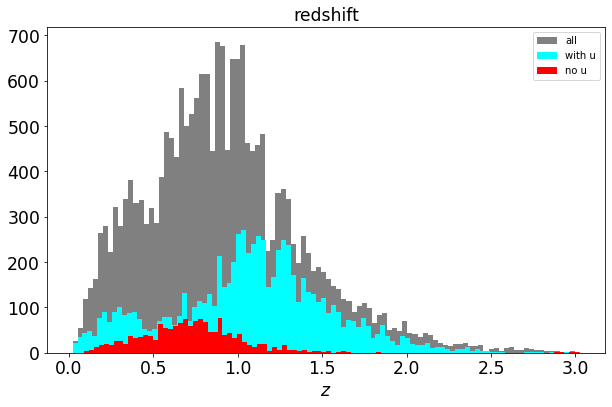

In [146]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
ax.hist(rs_all,bins=100,facecolor="grey",label="all");
ax.hist(rs,bins=100,facecolor="cyan",label="with u");
ax.hist(rs_no_u,bins=100,facecolor="r",alpha=1,label="no u");
ax.set_xlabel("$z$")
ax.set_title("redshift")
ax.legend()

In [147]:
mag_max[3]

26.8

Elliptical 1
Spiral 1
Spiral 2
Starburst 1
Starburst 2
Starburst 3
Starburst 4
Starburst 5


[]

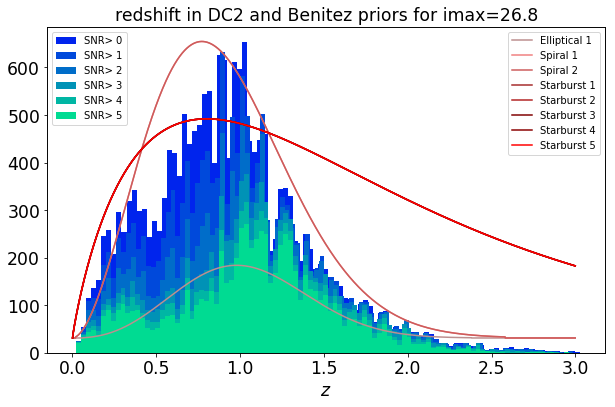

In [148]:
#sns.color_palette("rocket",len(nsig_set))
#sns.set_palette(sns.mpl_palette("GnBu_d"))
sns.set_palette(sns.mpl_palette("winter"))
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)

for idx in np.arange(0,len(nsig_set)):
    redshift_snr=all_data_f[idx][:,1]
    label=r"SNR> {}".format(nsig_set[idx])
    ax.hist(redshift_snr,bins=100,label=label);

ax.set_xlabel("$z$")
title="redshift in DC2 and Benitez priors for imax={}".format(mag_max[3])
ax.set_title(title)
ax.legend(loc="upper left")

ax2=ax.twinx()
#sns.set_palette(sns.mpl_palette("spring"))


colors = ['rosybrown', 'lightcoral', 'indianred', 'brown', 'firebrick', 'maroon','darkred', 'red', 'mystirose', 'salmon', 'tomato', 'darksalmon','coral', 'orangered', 'lightsalmon']

for idx in np.arange(nt):
    p=ax2.plot(z_grid, p_z__t_m[:,idx],"-",color=colors[idx] ,label=names[idx])
    #ax2.legend(p, labels=names)
    print(names[idx])
#ax.set_xlabel("z")
#ax.set_title("HDFN prior from Benitez 2000, adapted from the BPZ code.")
ax2.legend(loc="upper right")
# Turn off tick labels
ax2.set_yticklabels([])
ax2.set_yticks([])
#ax2.set_xticklabels([])

In [149]:
import pandas as pd
f_prior='prior/p_z_simulcosmos.xlsx'
df=pd.read_excel(f_prior)

In [150]:
my_z=np.linspace(0.001,3,100)

[]

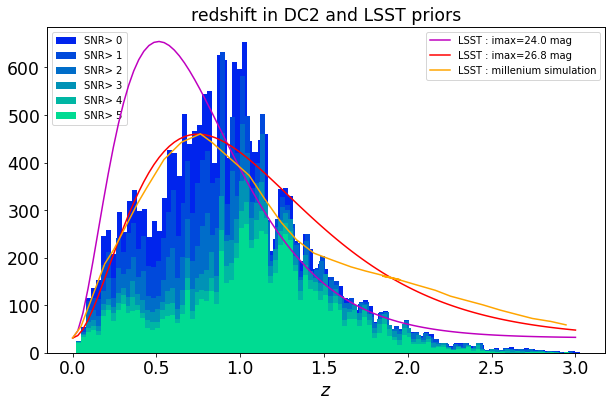

In [151]:
#sns.color_palette("rocket",len(nsig_set))
#sns.set_palette(sns.mpl_palette("GnBu_d"))
sns.set_palette(sns.mpl_palette("winter"))
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)

for idx in np.arange(0,len(nsig_set)):
    redshift_snr=all_data_f[idx][:,1]
    label=r"SNR> {}".format(nsig_set[idx])
    ax.hist(redshift_snr,bins=100,label=label);

ax.set_xlabel("$z$")
title = "redshift in DC2 and LSST priors"
ax.set_title(title)
ax.legend(loc="upper left")

ax2=ax.twinx()
#sns.set_palette(sns.mpl_palette("spring"))


colors = ['rosybrown', 'lightcoral', 'indianred', 'brown', 'firebrick', 'maroon','darkred', 'red', 'mystirose', 'salmon', 'tomato', 'darksalmon','coral', 'orangered', 'lightsalmon']

ax2.plot(my_z, photoz_lsst_prior(my_z,mag_min[3]),"m-",label="LSST : imax={} mag".format(mag_min[3]))
ax2.plot(my_z, photoz_lsst_prior(my_z,mag_max[3]),"r",label="LSST : imax={} mag".format(mag_max[3]))
ax2.plot(df["z"],df["prior"],"orange",label="LSST : millenium simulation")
#ax.set_xlabel("z")
#ax.set_title("HDFN prior from Benitez 2000, adapted from the BPZ code.")
ax2.legend(loc="upper right")
ax2.set_yticklabels([])
ax2.set_yticks([])

# Magnitudes

In [152]:
def mag_errors(mtrue, m5=24.0, fGamma=0.039):
    """
    compute magnitude errors based on the true magnitude and the
    5-sigma limiting magnitude, m5
    LSST science book
    """
    x = 10 ** (0.4 * (mtrue - m5))
    return np.sqrt((0.04 - fGamma) * x + fGamma * x ** 2)

## U filter

Text(0.5, 0.98, 'magnitude u')

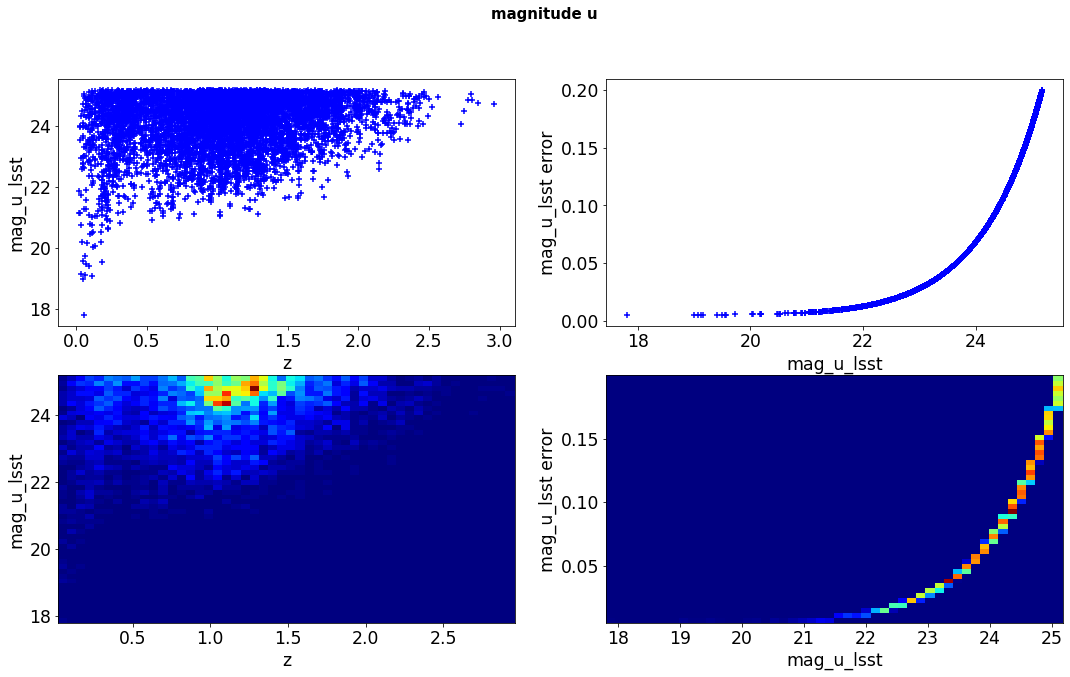

In [153]:
fig=plt.figure(figsize=(18,10))
ax=fig.add_subplot(221)
ax.scatter(rs,u,marker="+",color="b")
#ax.set_ylim(15,35)
ax.set_xlabel("z")
ax.set_ylabel("mag_u_lsst")
ax=fig.add_subplot(222)
ax.scatter(u,eu,marker="+",color="b")
#ax.set_xlim(15,35)
ax.set_xlabel("mag_u_lsst")
ax.set_ylabel("mag_u_lsst error")
plt.suptitle("magnitude u",fontweight='bold',fontsize=15)

ax=fig.add_subplot(223)
ax.hist2d(rs,u,(50,50),cmap="jet")
#ax.set_ylim(15,35)
ax.set_xlabel("z")
ax.set_ylabel("mag_u_lsst")
ax=fig.add_subplot(224)
ax.hist2d(u,eu,(50,50),cmap="jet")
#ax.set_xlim(15,35)
ax.set_xlabel("mag_u_lsst")
ax.set_ylabel("mag_u_lsst error")
plt.suptitle("magnitude u",fontweight='bold',fontsize=15)

Text(0.5, 0.98, 'magnitude u')

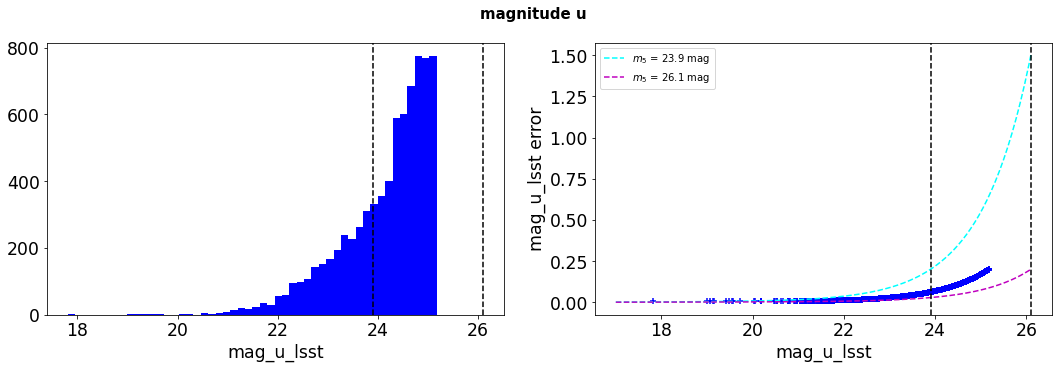

In [178]:
fig=plt.figure(figsize=(18,5))

filt_idx=0
mag_grid = np.linspace(17, mag_max[filt_idx], num=200)  # grid for i magnitude : 17 saturation, 28 2 mag above 5sigma thres


ax=fig.add_subplot(121)
ax.hist(u,bins=50,color="b");
ax.set_xlabel("mag_u_lsst")
ax.axvline(x=mag_min[filt_idx],color="k",ls='dashed')
ax.axvline(x=mag_max[filt_idx],color="k",ls='dashed')

ax=fig.add_subplot(122)
ax.scatter(u,eu,marker="+",color="b")
ax.set_xlabel("mag_u_lsst")
ax.set_ylabel("mag_u_lsst error")

label_min = "$m_5$ = {} mag ".format(mag_min[filt_idx])
label_max = "$m_5$ = {} mag ".format(mag_max[filt_idx])

ax.plot(mag_grid,mag_errors(mag_grid,m5=mag_min[filt_idx]),color="cyan",ls='dashed',label=label_min)
ax.plot(mag_grid,mag_errors(mag_grid,m5=mag_max[filt_idx]),color="m",ls='dashed',label=label_max)


ax.axvline(x=mag_min[filt_idx],color="k",ls='dashed')
ax.axvline(x=mag_max[filt_idx],color="k",ls='dashed')
ax.legend(loc="upper left")

plt.suptitle("magnitude u",fontweight='bold',fontsize=15)

## filter G 

Text(0.5, 0.98, 'magnitude g')

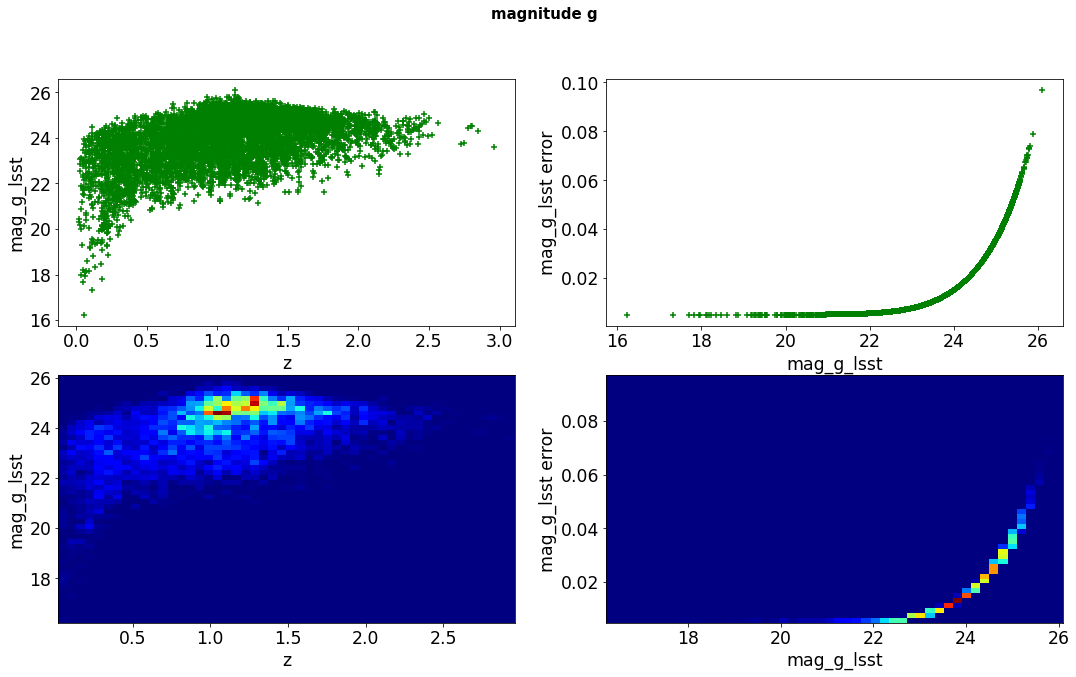

In [154]:
fig=plt.figure(figsize=(18,10))
ax=fig.add_subplot(221)
ax.scatter(rs,g,marker="+",color="g")
#ax.set_ylim(15,30)
ax.set_xlabel("z")
ax.set_ylabel("mag_g_lsst")
ax=fig.add_subplot(222)
ax.scatter(g,eg,marker="+",color="g")
#ax.set_xlim(15,30)
ax.set_xlabel("mag_g_lsst")
ax.set_ylabel("mag_g_lsst error")
plt.suptitle("magnitude g",fontweight='bold',fontsize=15)

ax=fig.add_subplot(223)
ax.hist2d(rs,g,(50,50),cmap="jet")
#ax.set_ylim(15,30)
ax.set_xlabel("z")
ax.set_ylabel("mag_g_lsst")
ax=fig.add_subplot(224)
ax.hist2d(g,eg,(50,50),cmap="jet")
#ax.set_xlim(15,30)
ax.set_xlabel("mag_g_lsst")
ax.set_ylabel("mag_g_lsst error")
plt.suptitle("magnitude g",fontweight='bold',fontsize=15)

Text(0.5, 0.98, 'magnitude g')

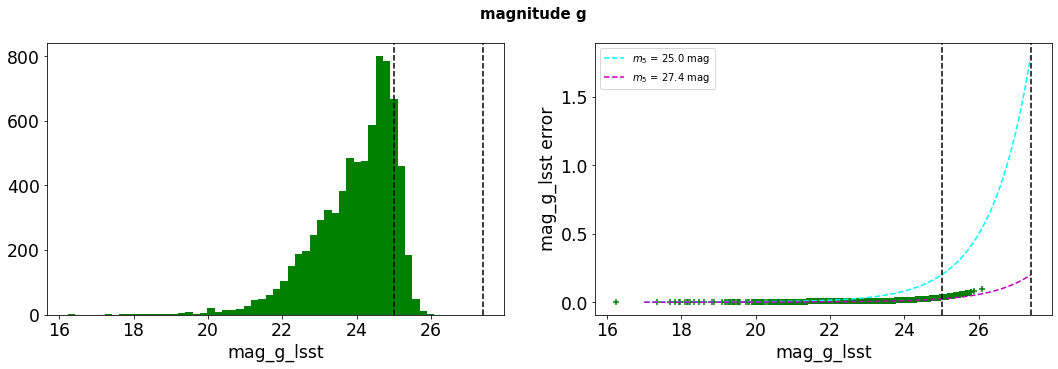

In [181]:
fig=plt.figure(figsize=(18,5))

filt_idx=1
mag_grid = np.linspace(17, mag_max[filt_idx], num=200)  # grid for i magnitude : 17 saturation, 28 2 mag above 5sigma thres


ax=fig.add_subplot(121)
ax.hist(g,bins=50,color="g");
ax.set_xlabel("mag_g_lsst")
ax.axvline(x=mag_min[filt_idx],color="k",ls='dashed')
ax.axvline(x=mag_max[filt_idx],color="k",ls='dashed')

ax=fig.add_subplot(122)
ax.scatter(g,eg,marker="+",color="g")
ax.set_xlabel("mag_g_lsst")
ax.set_ylabel("mag_g_lsst error")

label_min = "$m_5$ = {} mag ".format(mag_min[filt_idx])
label_max = "$m_5$ = {} mag ".format(mag_max[filt_idx])

ax.plot(mag_grid,mag_errors(mag_grid,m5=mag_min[filt_idx]),color="cyan",ls='dashed',label=label_min)
ax.plot(mag_grid,mag_errors(mag_grid,m5=mag_max[filt_idx]),color="m",ls='dashed',label=label_max)


ax.axvline(x=mag_min[filt_idx],color="k",ls='dashed')
ax.axvline(x=mag_max[filt_idx],color="k",ls='dashed')
ax.legend(loc="upper left")

plt.suptitle("magnitude g",fontweight='bold',fontsize=15)

## Filter R

Text(0.5, 0.98, 'magnitude r')

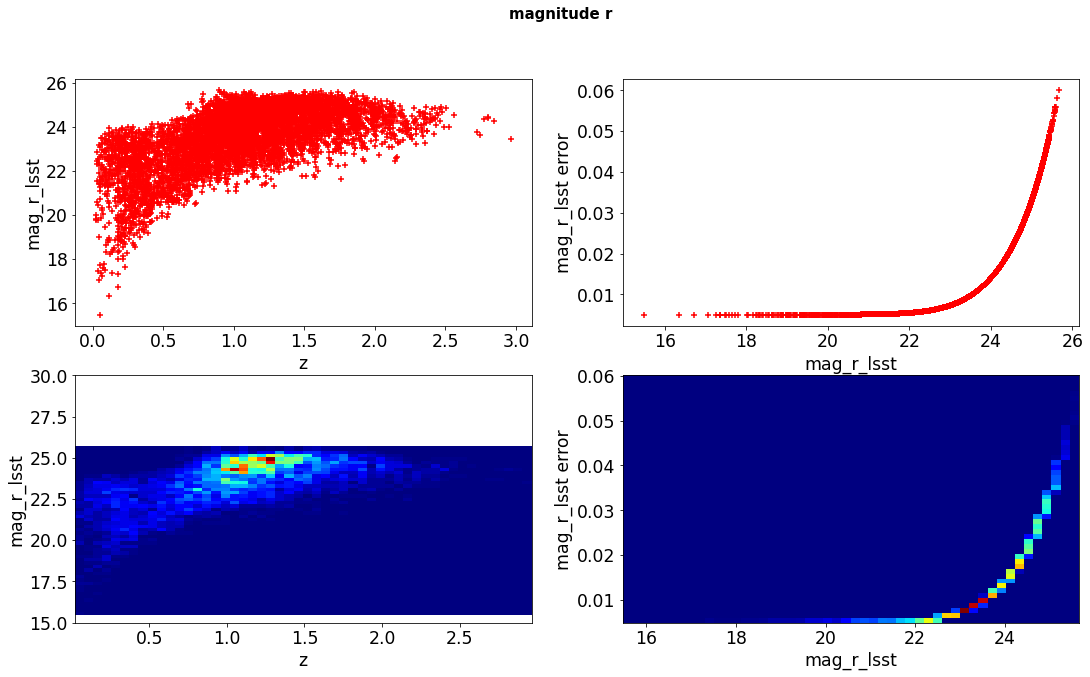

In [155]:
fig=plt.figure(figsize=(18,10))
ax=fig.add_subplot(221)
ax.scatter(rs,r,marker="+",color="r")
#ax.set_ylim(15,30)
ax.set_xlabel("z")
ax.set_ylabel("mag_r_lsst")
ax=fig.add_subplot(222)
ax.scatter(r,er,marker="+",color="r")
#ax.set_xlim(15,30)
ax.set_xlabel("mag_r_lsst")
ax.set_ylabel("mag_r_lsst error")
plt.suptitle("magnitude r",fontweight='bold',fontsize=15)

ax=fig.add_subplot(223)
ax.hist2d(rs,r,(50,50),cmap="jet")
ax.set_ylim(15,30)
ax.set_xlabel("z")
ax.set_ylabel("mag_r_lsst")
ax=fig.add_subplot(224)
ax.hist2d(r,er,(50,50),cmap="jet")
#ax.set_xlim(15,30)
ax.set_xlabel("mag_r_lsst")
ax.set_ylabel("mag_r_lsst error")
plt.suptitle("magnitude r",fontweight='bold',fontsize=15)

Text(0.5, 0.98, 'magnitude r')

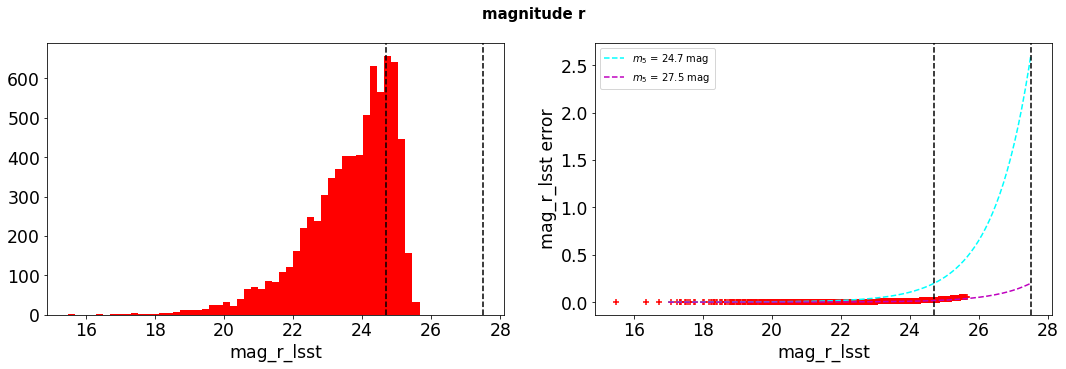

In [182]:
fig=plt.figure(figsize=(18,5))

filt_idx=2
mag_grid = np.linspace(17, mag_max[filt_idx], num=200)  # grid for i magnitude : 17 saturation, 28 2 mag above 5sigma thres


ax=fig.add_subplot(121)
ax.hist(r,bins=50,color="r");
ax.set_xlabel("mag_r_lsst")
ax.axvline(x=mag_min[filt_idx],color="k",ls='dashed')
ax.axvline(x=mag_max[filt_idx],color="k",ls='dashed')

ax=fig.add_subplot(122)
ax.scatter(r,er,marker="+",color="r")
ax.set_xlabel("mag_r_lsst")
ax.set_ylabel("mag_r_lsst error")

label_min = "$m_5$ = {} mag ".format(mag_min[filt_idx])
label_max = "$m_5$ = {} mag ".format(mag_max[filt_idx])

ax.plot(mag_grid,mag_errors(mag_grid,m5=mag_min[filt_idx]),color="cyan",ls='dashed',label=label_min)
ax.plot(mag_grid,mag_errors(mag_grid,m5=mag_max[filt_idx]),color="m",ls='dashed',label=label_max)


ax.axvline(x=mag_min[filt_idx],color="k",ls='dashed')
ax.axvline(x=mag_max[filt_idx],color="k",ls='dashed')
ax.legend(loc="upper left")

plt.suptitle("magnitude r",fontweight='bold',fontsize=15)

## Filter i

Text(0.5, 0.98, 'magnitude i')

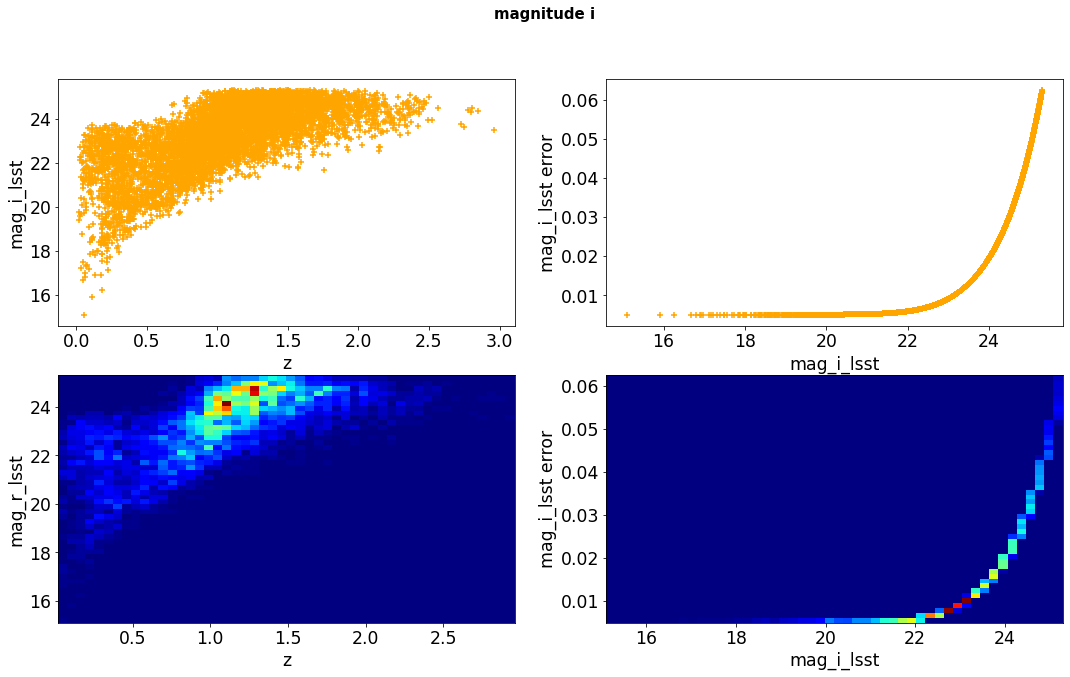

In [156]:
fig=plt.figure(figsize=(18,10))
ax=fig.add_subplot(221)
ax.scatter(rs,i,marker="+",color="orange")
#ax.set_ylim(15,30)
ax.set_xlabel("z")
ax.set_ylabel("mag_i_lsst")
ax=fig.add_subplot(222)
ax.scatter(i,ei,marker="+",color="orange")
#ax.set_xlim(15,30)
ax.set_xlabel("mag_i_lsst")
ax.set_ylabel("mag_i_lsst error")
plt.suptitle("magnitude i",fontweight='bold',fontsize=15)

ax=fig.add_subplot(223)
ax.hist2d(rs,i,(50,50),cmap="jet")
#ax.set_ylim(15,30)
ax.set_xlabel("z")
ax.set_ylabel("mag_r_lsst")
ax=fig.add_subplot(224)
ax.hist2d(i,ei,(50,50),cmap="jet")
#ax.set_xlim(15,30)
ax.set_xlabel("mag_i_lsst")
ax.set_ylabel("mag_i_lsst error")
plt.suptitle("magnitude i",fontweight='bold',fontsize=15)

Text(0.5, 0.98, 'magnitude i')

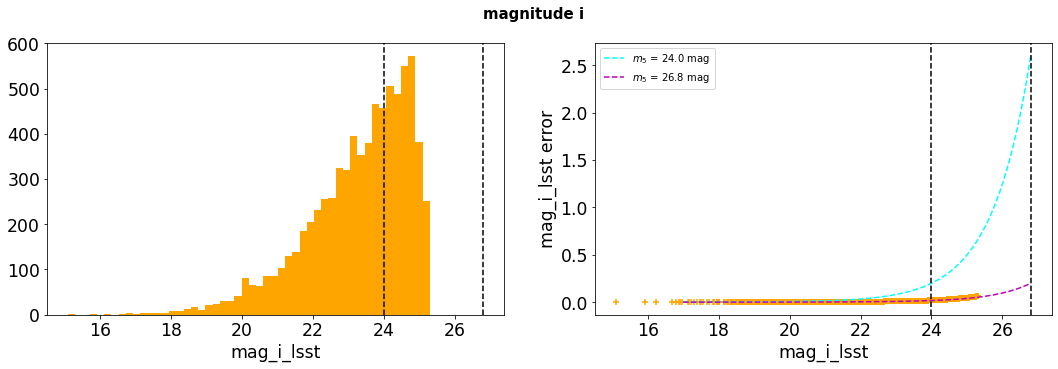

In [184]:
fig=plt.figure(figsize=(18,5))

filt_idx=3
mag_grid = np.linspace(17, mag_max[filt_idx], num=200)  # grid for i magnitude : 17 saturation, 28 2 mag above 5sigma thres


ax=fig.add_subplot(121)
ax.hist(i,bins=50,color="orange");
ax.set_xlabel("mag_i_lsst")
ax.axvline(x=mag_min[filt_idx],color="k",ls='dashed')
ax.axvline(x=mag_max[filt_idx],color="k",ls='dashed')

ax=fig.add_subplot(122)
ax.scatter(i,ei,marker="+",color="orange")
ax.set_xlabel("mag_i_lsst")
ax.set_ylabel("mag_i_lsst error")

label_min = "$m_5$ = {} mag ".format(mag_min[filt_idx])
label_max = "$m_5$ = {} mag ".format(mag_max[filt_idx])

ax.plot(mag_grid,mag_errors(mag_grid,m5=mag_min[filt_idx]),color="cyan",ls='dashed',label=label_min)
ax.plot(mag_grid,mag_errors(mag_grid,m5=mag_max[filt_idx]),color="m",ls='dashed',label=label_max)


ax.axvline(x=mag_min[filt_idx],color="k",ls='dashed')
ax.axvline(x=mag_max[filt_idx],color="k",ls='dashed')
ax.legend(loc="upper left")

plt.suptitle("magnitude i",fontweight='bold',fontsize=15)

## Filter z

Text(0.5, 0.98, 'magnitude z')

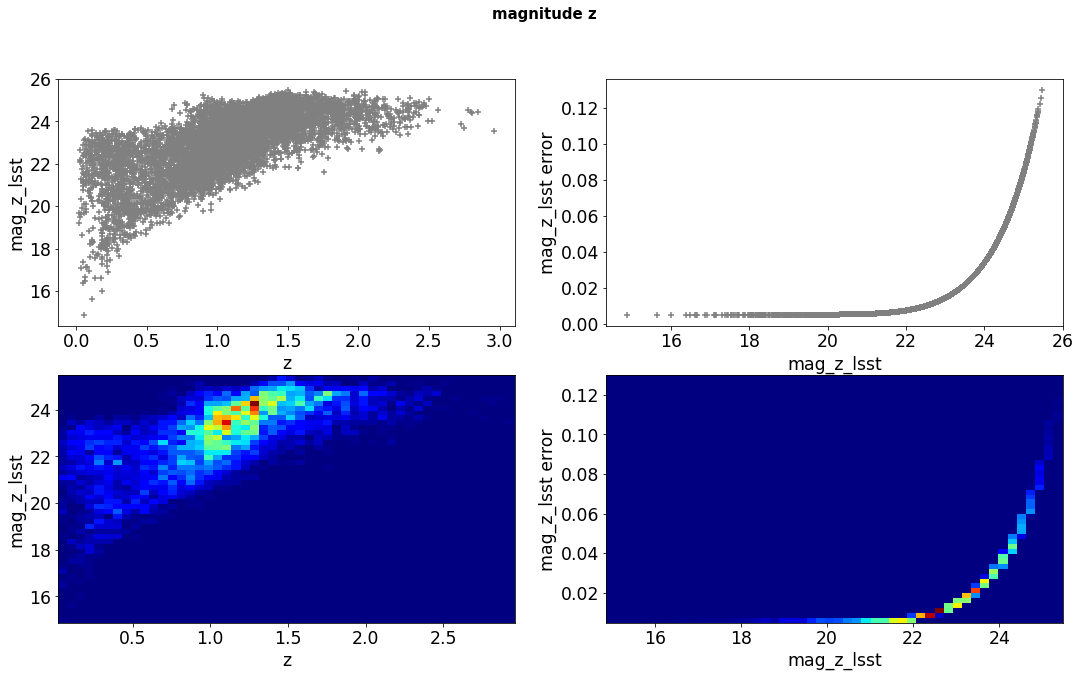

In [157]:
fig=plt.figure(figsize=(18,10))
ax=fig.add_subplot(221)
ax.scatter(rs,z,marker="+",color="grey")
#ax.set_ylim(15,30)
ax.set_xlabel("z")
ax.set_ylabel("mag_z_lsst")
ax=fig.add_subplot(222)
ax.scatter(z,ez,marker="+",color="grey")
#ax.set_xlim(15,30)
ax.set_xlabel("mag_z_lsst")
ax.set_ylabel("mag_z_lsst error")
plt.suptitle("magnitude z",fontweight='bold',fontsize=15)

ax=fig.add_subplot(223)
ax.hist2d(rs,z,(50,50),cmap="jet")
#ax.set_ylim(15,30)
ax.set_xlabel("z")
ax.set_ylabel("mag_z_lsst")
ax=fig.add_subplot(224)
ax.hist2d(z,ez,(50,50),cmap="jet")
#ax.set_xlim(15,30)
ax.set_xlabel("mag_z_lsst")
ax.set_ylabel("mag_z_lsst error")
plt.suptitle("magnitude z",fontweight='bold',fontsize=15)

Text(0.5, 0.98, 'magnitude z')

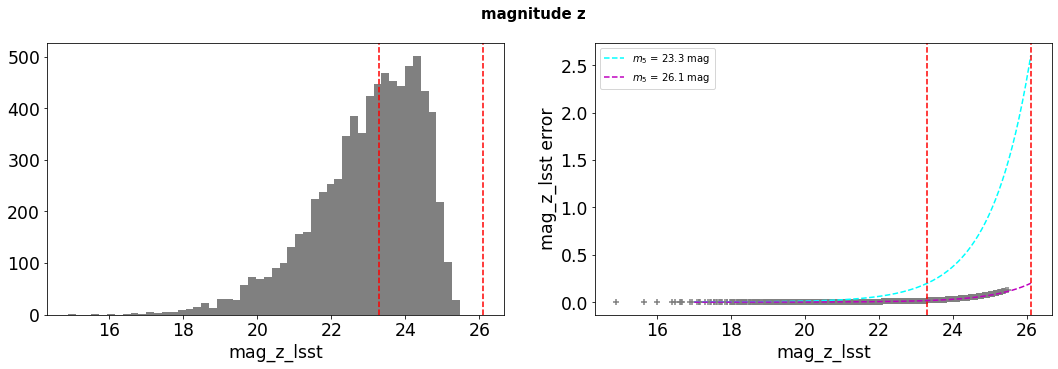

In [188]:
fig=plt.figure(figsize=(18,5))

filt_idx=4
mag_grid = np.linspace(17, mag_max[filt_idx], num=200)  # grid for i magnitude : 17 saturation, 28 2 mag above 5sigma thres


ax=fig.add_subplot(121)
ax.hist(z,bins=50,color="grey");
ax.set_xlabel("mag_z_lsst")
ax.axvline(x=mag_min[filt_idx],color="r",ls='dashed')
ax.axvline(x=mag_max[filt_idx],color="r",ls='dashed')

ax=fig.add_subplot(122)
ax.scatter(z,ez,marker="+",color="grey")
ax.set_xlabel("mag_z_lsst")
ax.set_ylabel("mag_z_lsst error")

label_min = "$m_5$ = {} mag ".format(mag_min[filt_idx])
label_max = "$m_5$ = {} mag ".format(mag_max[filt_idx])

ax.plot(mag_grid,mag_errors(mag_grid,m5=mag_min[filt_idx]),color="cyan",ls='dashed',label=label_min)
ax.plot(mag_grid,mag_errors(mag_grid,m5=mag_max[filt_idx]),color="m",ls='dashed',label=label_max)


ax.axvline(x=mag_min[filt_idx],color="r",ls='dashed')
ax.axvline(x=mag_max[filt_idx],color="r",ls='dashed')
ax.legend(loc="upper left")

plt.suptitle("magnitude z",fontweight='bold',fontsize=15)

## Filter Y

Text(0.5, 0.98, 'magnitude y')

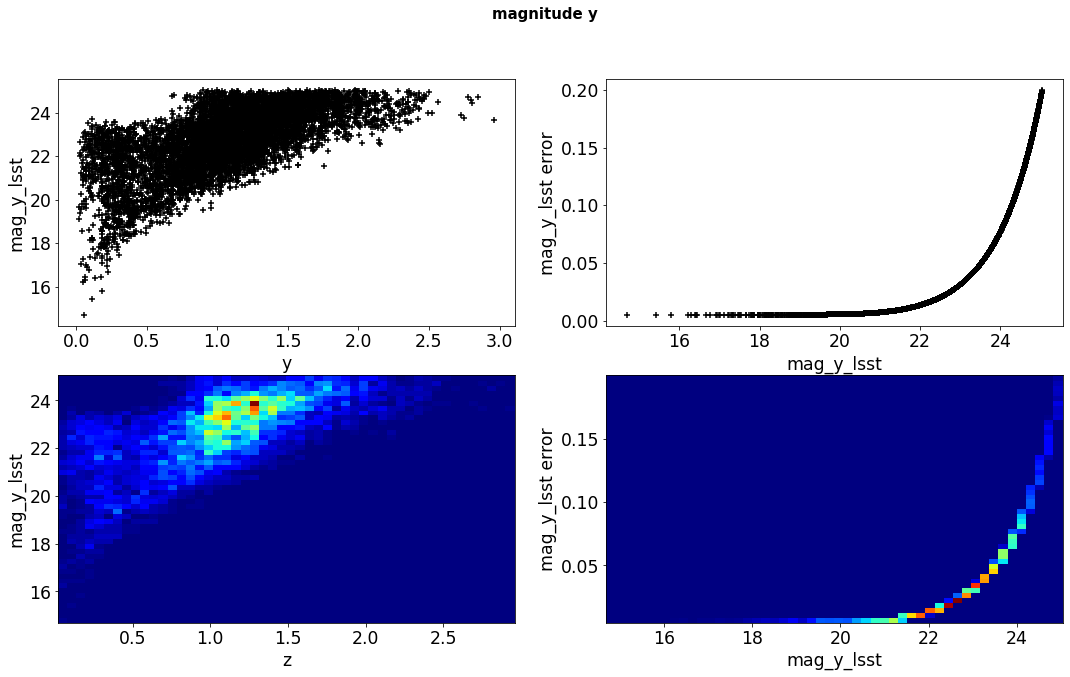

In [158]:
fig=plt.figure(figsize=(18,10))
ax=fig.add_subplot(221)
ax.scatter(rs,y,marker="+",color="k")
#ax.set_ylim(15,30)
ax.set_xlabel("y")
ax.set_ylabel("mag_y_lsst")
ax=fig.add_subplot(222)
ax.scatter(y,ey,marker="+",color="k")
#ax.set_xlim(15,30)
ax.set_xlabel("mag_y_lsst")
ax.set_ylabel("mag_y_lsst error")
plt.suptitle("magnitude y",fontweight='bold',fontsize=15)

ax=fig.add_subplot(223)
ax.hist2d(rs,y,(50,50),cmap="jet")
#ax.set_ylim(15,30)
ax.set_xlabel("z")
ax.set_ylabel("mag_y_lsst")
ax=fig.add_subplot(224)
ax.hist2d(y,ey,(50,50),cmap="jet")
#ax.set_xlim(15,30)
ax.set_xlabel("mag_y_lsst")
ax.set_ylabel("mag_y_lsst error")
plt.suptitle("magnitude y",fontweight='bold',fontsize=15)

Text(0.5, 0.98, 'magnitude y')

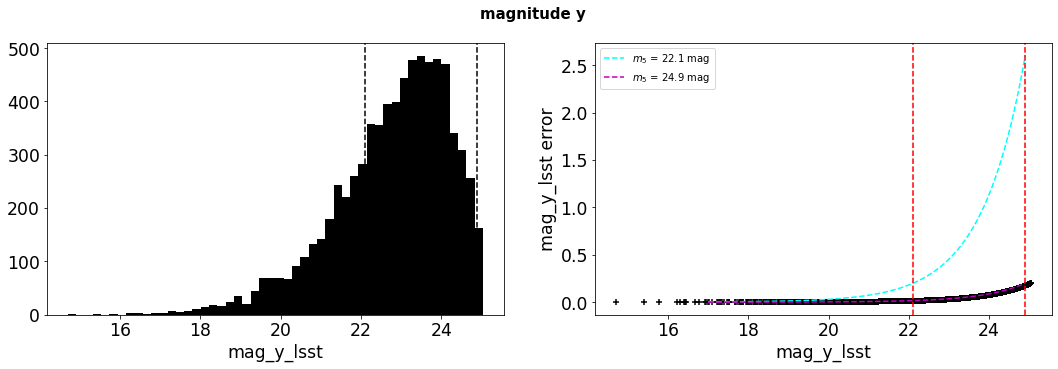

In [187]:
fig=plt.figure(figsize=(18,5))

filt_idx=5
mag_grid = np.linspace(17, mag_max[filt_idx], num=200)  # grid for i magnitude : 17 saturation, 28 2 mag above 5sigma thres


ax=fig.add_subplot(121)
ax.hist(y,bins=50,color="k");
ax.set_xlabel("mag_y_lsst")
ax.axvline(x=mag_min[filt_idx],color="r",ls='dashed')
ax.axvline(x=mag_max[filt_idx],color="r",ls='dashed')

ax=fig.add_subplot(122)
ax.scatter(y,ey,marker="+",color="k")
ax.set_xlabel("mag_y_lsst")
ax.set_ylabel("mag_y_lsst error")

label_min = "$m_5$ = {} mag ".format(mag_min[filt_idx])
label_max = "$m_5$ = {} mag ".format(mag_max[filt_idx])

ax.plot(mag_grid,mag_errors(mag_grid,m5=mag_min[filt_idx]),color="cyan",ls='dashed',label=label_min)
ax.plot(mag_grid,mag_errors(mag_grid,m5=mag_max[filt_idx]),color="m",ls='dashed',label=label_max)


ax.axvline(x=mag_min[filt_idx],color="r",ls='dashed')
ax.axvline(x=mag_max[filt_idx],color="r",ls='dashed')
ax.legend(loc="upper left")

plt.suptitle("magnitude y",fontweight='bold',fontsize=15)

# Convert to flux

In [159]:
redshift=rs

In [160]:
flux_g_lsst=np.power(10,-0.4*g)
flux_i_lsst=np.power(10,-0.4*i)
flux_r_lsst=np.power(10,-0.4*r)
flux_u_lsst=np.power(10,-0.4*u)
flux_y_lsst=np.power(10,-0.4*y)
flux_z_lsst=np.power(10,-0.4*z)

In [161]:
flux_err_u = eu*flux_u_lsst
flux_err_g = eg*flux_g_lsst
flux_err_r = er*flux_r_lsst
flux_err_i = ei*flux_i_lsst
flux_err_z = ez*flux_z_lsst
flux_err_y = ey*flux_y_lsst

In [162]:
redshift=fdata[:,1]
flux_u_lsst=fdata[:,2]
flux_g_lsst=fdata[:,3]
flux_r_lsst=fdata[:,4]
flux_i_lsst=fdata[:,5]
flux_z_lsst=fdata[:,6]
flux_y_lsst=fdata[:,7]

flux_err_u=fdata[:,8] 
flux_err_g=fdata[:,9] 
flux_err_r=fdata[:,10] 
flux_err_i=fdata[:,11]
flux_err_z=fdata[:,12]
flux_err_y=fdata[:,13]

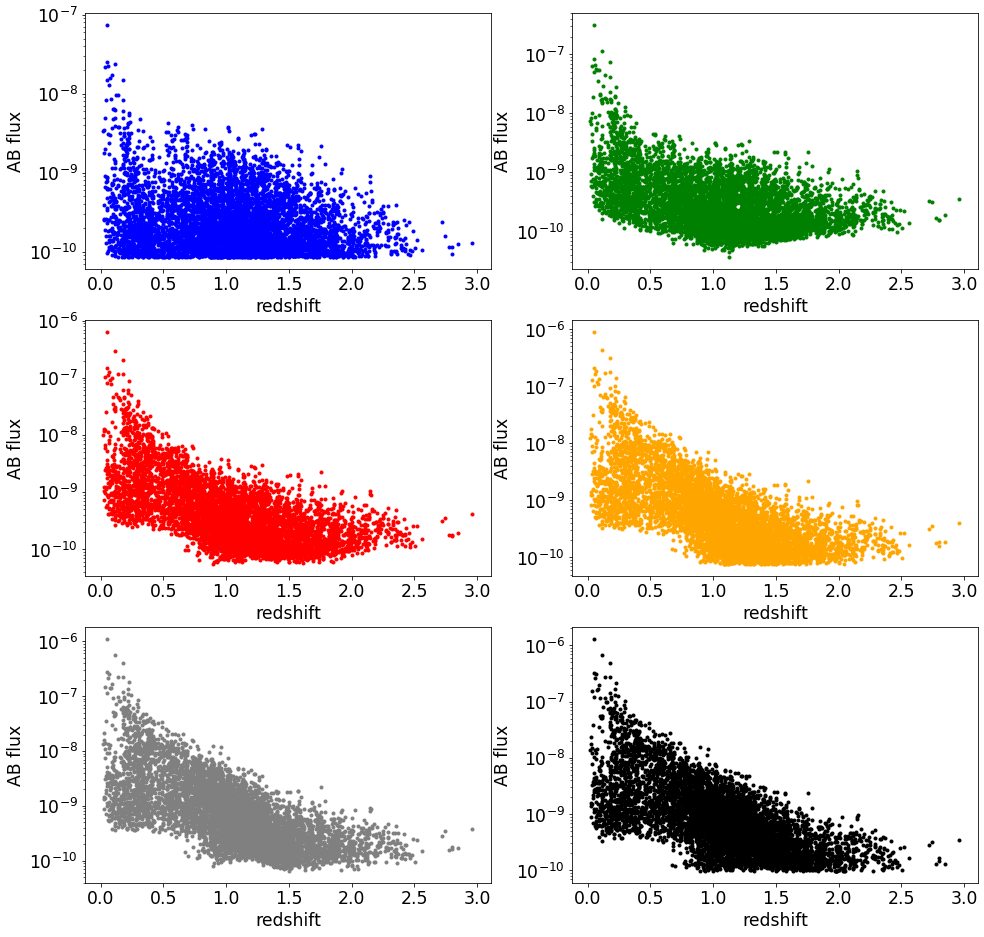

In [163]:
ncol=2
nrow=3
fig, axes = plt.subplots(nrow, ncol,figsize=(16,16)) 

for ifilt in np.arange(6):
    ix=ifilt//3
    iy=ifilt-ix*3
    
    if ifilt==0:
        axes[0,0].scatter(redshift,flux_u_lsst,marker=".",label="band u",color="b")
    elif ifilt==1:
        axes[0,1].scatter(redshift,flux_g_lsst,marker=".",label="band g",color="g")
    elif ifilt==2:
        axes[1,0].scatter(redshift,flux_r_lsst,marker=".",label="band r",color="r")
    elif ifilt==3:
        axes[1,1].scatter(redshift,flux_i_lsst,marker=".",label="band i",color="orange")
    elif ifilt==4:
        axes[2,0].scatter(redshift,flux_z_lsst,marker=".",label="band z",color="grey")
    elif ifilt==5:
        axes[2,1].scatter(redshift,flux_y_lsst,marker=".",label="band y",color="k")
        
    axes[iy,ix].set_yscale("log")
    axes[iy,ix].set_xlabel("redshift")
    axes[iy,ix].set_ylabel("AB flux")
     
        
        

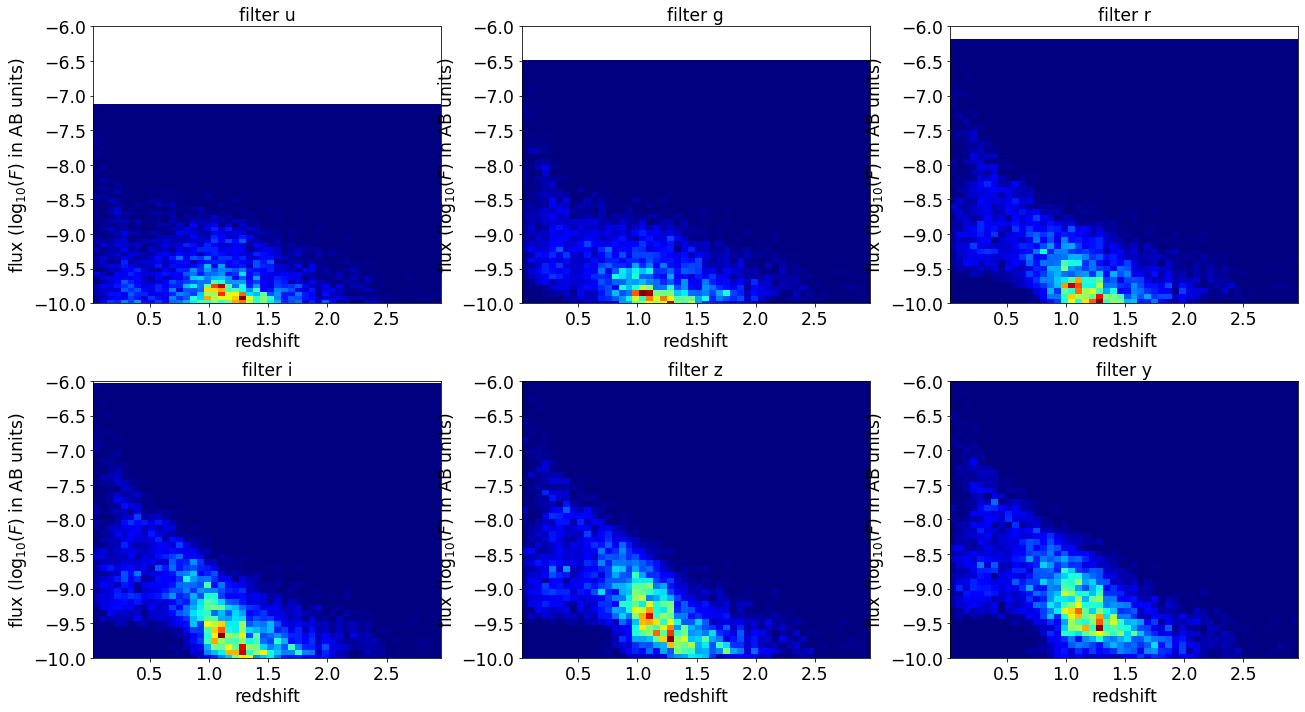

In [164]:
ncol=3
nrow=2
filtername=["filter u", "filter g","filter r","filter i","filter z","filter y"]
fig, axes = plt.subplots(nrow, ncol,figsize=(18,10)) 

for ifilt in np.arange(6):
   
    iy=ifilt//3
    ix=ifilt-iy*3
    
    #print(ifilt," iy=",iy," ix=",ix)
    
    if ifilt==0:
        axes[0,0].hist2d(redshift,np.log10(flux_u_lsst),(50,50),label="band u",cmap="jet")
        
    elif ifilt==1:
        axes[0,1].hist2d(redshift,np.log10(flux_g_lsst),(50,50),label="band g",cmap="jet")
    elif ifilt==2:
        axes[0,2].hist2d(redshift,np.log10(flux_r_lsst),(50,50),label="band r",cmap="jet")
    elif ifilt==3:
        axes[1,0].hist2d(redshift,np.log10(flux_i_lsst),(50,50),label="band i",cmap="jet")
    elif ifilt==4:
        axes[1,1].hist2d(redshift,np.log10(flux_z_lsst),(50,50),label="band z",cmap="jet")
    elif ifilt==5:
        axes[1,2].hist2d(redshift,np.log10(flux_y_lsst),(50,50),label="band y",cmap="jet")
        
    
    axes[iy,ix].set_title(filtername[ifilt])
    axes[iy,ix].set_xlabel("redshift")
    axes[iy,ix].set_ylabel("flux ($\log_{10}(F)$ in AB units)")
    axes[iy,ix].set_ylim(-10,-6)
     
plt.tight_layout()        